In [58]:
import numpy as np
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
import pickle
from plot import plot_hist, plot_conf_mat
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load in the preprocessed data

In [8]:
from save_utils import load_sliced_numpy_array

melspec_data = load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

print("Features:", melspec_data.shape)
print("Labels:", labels.shape)

Loaded 12 files:
    melspec_features_001.npy
    melspec_features_002.npy
    melspec_features_003.npy
    melspec_features_007.npy
    melspec_features_012.npy
    melspec_features_006.npy
    melspec_features_010.npy
    melspec_features_004.npy
    melspec_features_005.npy
    melspec_features_011.npy
    melspec_features_008.npy
    melspec_features_009.npy
Features: (4068, 33088)
Labels: (4068, 5)


Split the data into train and test set

In [9]:
train_size = 0.7
val_size = 0.2

mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=train_size, random_state=42)
mel_val, mel_test, lab_val, lab_test = train_test_split(mel_test_val, lab_test_val, test_size=(val_size/(1-train_size)), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]

print(mel_train.shape)
print(mel_test.shape)
print(mel_val.shape)

print(lab_train.shape)
print(lab_test.shape)
print(lab_val.shape)


(2847, 33088)
(814, 33088)
(407, 33088)
(2847, 5)
(814, 5)
(407, 5)


Normalize the data (3254, 64, 517)

In [10]:
def normalization(mel_train, mel_test, mel_val):
    maximum = np.amax(mel_train)
    mel_train = mel_train/maximum
    mel_test = mel_test/maximum
    mel_val = mel_val/maximum
    return (mel_train.astype(np.float32), mel_test.astype(np.float32), mel_val.astype(np.float32))

mel_train_n, mel_test_n, mel_val_n = normalization(mel_train, mel_test, mel_val)

Reshape the melspec the models dimensions

In [11]:
n_mels = 64
# .reshape(n_mels, -1)

# Reshaping Mel-Spectrogram
def reshape_melspectogram(mel_train, mel_test, mel_val):
    n, m = mel_train.shape
    mel_train = mel_train.reshape((n, n_mels, int(m/n_mels), 1))
    n, m = mel_test.shape
    mel_test = mel_test.reshape((n, n_mels, int(m/n_mels), 1))
    n, m = mel_val.shape
    mel_val = mel_val.reshape((n, n_mels, int(m/n_mels), 1))
    return mel_train, mel_test, mel_val

mel_train_n, mel_test_n, mel_val_n = reshape_melspectogram(mel_train_n, mel_test_n, mel_val_n)

print(mel_train_n.shape)
print(mel_test_n.shape)
print(mel_val_n.shape)

(2847, 64, 517, 1)
(814, 64, 517, 1)
(407, 64, 517, 1)


Define the shot-chunk-cnn model

In [12]:
# Define the model
def shortchunckcnn(input_shape, output_shape):
    model = Sequential()
    model.add(Conv2D(8, (3,3), activation= 'relu', input_shape=input_shape, padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Flatten())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dense(output_shape, activation= 'softmax'))

    model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = shortchunckcnn(mel_train_n[0].shape, labels.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 517, 8)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 130, 8)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 130, 16)       1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 33, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 33, 32)         4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 9, 32)         0

2022-12-20 16:24:38.148185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
Total params: 63,557
Trainable params: 63,557
Non-trainable params: 0
_________________________________________________________________


Train the defined model

In [13]:
callbacks = [
    ModelCheckpoint("models/short_chunk_cnn_{epoch:03d}.h5", save_freq=5),
    EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)
]

epochs=100

history = model.fit(mel_train_n, lab_train, epochs=epochs, validation_data=(mel_val_n, lab_val), callbacks=callbacks, batch_size=32, verbose=1)

Epoch 1/100
89/89 [==============================] - 11s 109ms/step - loss: 1.5464 - accuracy: 0.3021 - val_loss: 1.4723 - val_accuracy: 0.3194
Epoch 2/100
89/89 [==============================] - 9s 103ms/step - loss: 1.4889 - accuracy: 0.3302 - val_loss: 1.4583 - val_accuracy: 0.3096
Epoch 3/100
89/89 [==============================] - 9s 96ms/step - loss: 1.4833 - accuracy: 0.3186 - val_loss: 1.4466 - val_accuracy: 0.3194
Epoch 4/100
89/89 [==============================] - 9s 96ms/step - loss: 1.4623 - accuracy: 0.3411 - val_loss: 1.4394 - val_accuracy: 0.3317
Epoch 5/100
89/89 [==============================] - 9s 96ms/step - loss: 1.4563 - accuracy: 0.3393 - val_loss: 1.4253 - val_accuracy: 0.3292
Epoch 6/100
89/89 [==============================] - 9s 96ms/step - loss: 1.4479 - accuracy: 0.3425 - val_loss: 1.4149 - val_accuracy: 0.3735
Epoch 7/100
89/89 [==============================] - 9s 97ms/step - loss: 1.4441 - accuracy: 0.3407 - val_loss: 1.4128 - val_accuracy: 0.3784
Epo

Save the history from training to file

In [14]:
with open('models/short_chunk_cnn_history', 'wb') as f:
    pickle.dump(history.history, f)

model.save("models/short_chunk_cnn_complete_{epochs}.h5".format(epochs=epochs))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


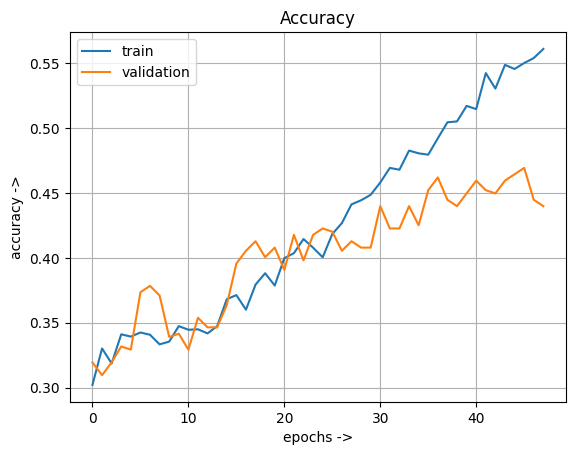

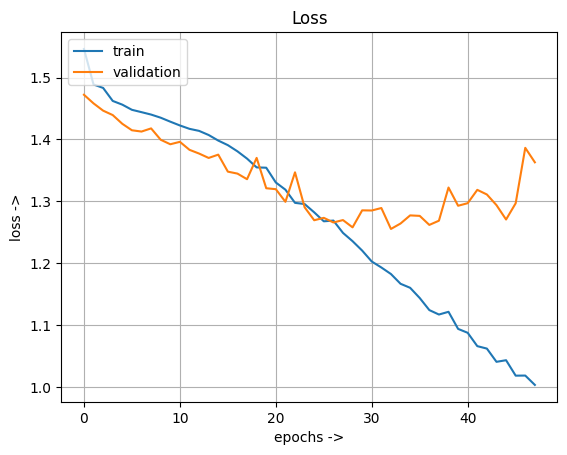

In [16]:
with open('models/short_chunk_cnn_history', "rb") as f:
    history = pickle.load(f)

print(history.keys())

plot_hist(history, ('accuracy', 'val_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->')

plot_hist(history, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->')

Make predictions for the 3 sets

In [24]:
predict = lambda model, data: np.argmax(model.predict(data), axis=-1)

model = load_model(f"models/short_chunk_cnn_complete_{epochs}.h5")

# Training prediction
y_pred_train = predict(model, mel_train_n)
y_true_train = np.argmax(lab_train, axis= -1)
print(f"ACCURACY FOR TRAIN SET {accuracy_score(y_true_train, y_pred_train)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='micro')*100:.4f} %")


# Validation prediction
y_pred_val = predict(model, mel_val_n)
y_true_val = np.argmax(lab_val, axis= -1)
print(f"ACCURACY FOR VAL SET {accuracy_score(y_true_val, y_pred_val)*100:.4f} %")
print(f"MACRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='micro')*100:.4f} %")

# Test prediction
y_pred_test = predict(model, mel_test_n)
y_true_test = np.argmax(lab_test, axis= -1)
print(f"ACCURACY FOR TEST SET {accuracy_score(y_true_test, y_pred_test)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='micro')*100:.4f} %")

89/89 [==============================] - 3s 30ms/step
ACCURACY FOR TRAIN SET 49.2799 %
MACRO F1 SCORE FOR TRAIN SET 48.2340 %
MICRO F1 SCORE FOR TRAIN SET 49.2799 %
13/13 [==============================] - 0s 29ms/step
ACCURACY FOR VAL SET 42.2604 %
MACRO F1 SCORE FOR VAL SET 40.0803 %
MICRO F1 SCORE FOR VAL SET 42.2604 %
26/26 [==============================] - 1s 27ms/step
ACCURACY FOR TEST SET 39.3120 %
MACRO F1 SCORE FOR TEST SET 38.0975 %
MICRO F1 SCORE FOR TEST SET 39.3120 %


# Plot the confusion matrix on the test set
horizontal: predicted labels  
vertical: true labels

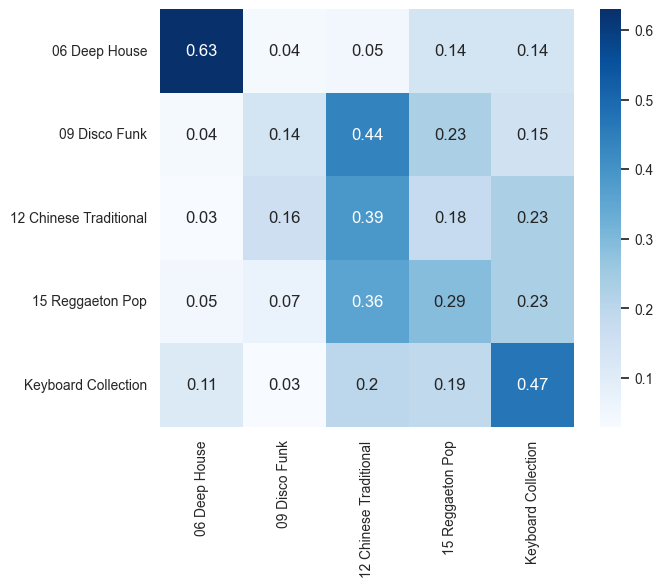

In [59]:
with open('data/class_label_index_mapping.txt', 'r') as f:
    class_names = list(map(lambda s: s.split(':')[0], f.readlines()))

conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

plot_conf_mat(conf_mat_df, save_to=f"Plots/short_chunk_cnn_{epochs}_test_conf_mat.png")